# Fit motor voltage → speed power model (2022)

This notebook fits a simple monotone power-law model:

\[ v\_{km/h} = k \cdot \max(motor_v - v_0, 0)^{a} \]

where `motor_v = batt_v * esc_dt`. It writes a CSV with `k,a,v0` used by `model.py`.


In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [2]:
DATA_2022 = Path(os.getcwd()).resolve().parent / "boat_data_1s.csv"
OUT_CSV = (
    Path(os.getcwd()).resolve() / "data" / "motor_voltage_speed_power_model_2022.csv"
)
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_2022)
df["gps_speed"] = df["gps_speed"].rolling(10, center=True).mean()
df = df[(df["gps_speed"] > 0.8) & (df["gps_speed"] < 30)].dropna(
    subset=["gps_speed", "batt_po", "batt_v", "esc_dt", "timestamp"]
)

ts = pd.to_numeric(df["timestamp"], errors="coerce").to_numpy(dtype=float)
dt = 1.0
mask = np.isfinite(ts)
if mask.sum() > 2:
    d = np.diff(ts[mask])
    if len(d):
        dt = float(np.nanmedian(d))

V_mps = df["gps_speed"] / 3.6
P = df["batt_po"]
dv_dt = V_mps.diff() / dt
dp_dt = P.diff() / dt

steady = (dv_dt.abs().fillna(0) < 0.05) & (dp_dt.abs().fillna(0) < 200.0) & (P > 0)
df_ss = df.loc[steady].copy()
df_ss["motor_v"] = df_ss["batt_v"] * df_ss["esc_dt"]

motor_v = df_ss["motor_v"].to_numpy(dtype=float)
speed_kmh = df_ss["gps_speed"].to_numpy(dtype=float)

motor_v = np.concatenate([[0.0], motor_v])
speed_kmh = np.concatenate([[0.0], speed_kmh])

mask = np.isfinite(motor_v) & np.isfinite(speed_kmh) & (motor_v >= 0) & (speed_kmh >= 0)
motor_v = motor_v[mask]
speed_kmh = speed_kmh[mask]

print("steady points:", len(df_ss))
print("motor_v min/max:", float(np.min(motor_v)), float(np.max(motor_v)))
print("speed min/max (km/h):", float(np.min(speed_kmh)), float(np.max(speed_kmh)))

steady points: 4155
motor_v min/max: 0.0 36.290176
speed min/max (km/h): 0.0 26.79172361643602


In [3]:
def predict(theta, mv):
    k, a, v0 = theta
    xeff = np.maximum(mv - v0, 0.0)
    return k * np.power(xeff, a)


def resid(theta):
    return predict(theta, motor_v) - speed_kmh


xeff = np.maximum(motor_v, 1e-9)
k0 = float(np.nanmedian(speed_kmh[speed_kmh > 0] / xeff[speed_kmh > 0]))
if not np.isfinite(k0) or k0 <= 0:
    k0 = 0.6

theta0 = np.array([k0, 1.0, 0.0], dtype=float)
lb = np.array([1e-6, 1e-3, 0.0], dtype=float)
ub = np.array([1e3, 5.0, 50.0], dtype=float)

res = least_squares(
    resid, x0=theta0, bounds=(lb, ub), loss="soft_l1", f_scale=0.5, max_nfev=20000
)
k, a, v0 = res.x
rmse = float(np.sqrt(np.mean(res.fun**2)))
print("k,a,v0:", float(k), float(a), float(v0))
print("RMSE (km/h):", rmse)

pd.DataFrame(
    {
        "k": [k],
        "a": [a],
        "v0": [v0],
        "motor_v_min": [float(np.min(motor_v))],
        "motor_v_max": [float(np.max(motor_v))],
    }
).to_csv(OUT_CSV, index=False)
print("wrote:", OUT_CSV)

k,a,v0: 2.460330019741143 0.6109103174709903 7.965297002554943
RMSE (km/h): 0.9232407955849139
wrote: /home/joaoantoniocardoso/workspace_TCC/repo/solarboat_model/models/2022/hull/data/motor_voltage_speed_power_model_2022.csv


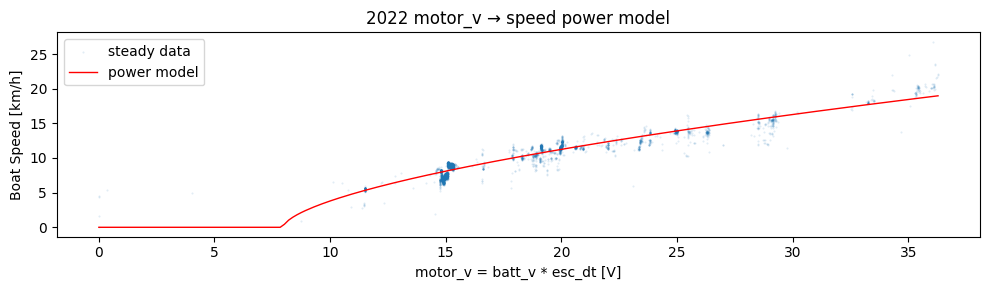

In [4]:
mv_grid = np.linspace(float(np.min(motor_v)), float(np.max(motor_v)), 200)
plt.figure(figsize=(10, 3))
plt.scatter(motor_v, speed_kmh, s=0.2, alpha=0.15, label="steady data")
plt.plot(mv_grid, predict([k, a, v0], mv_grid), "r", linewidth=1, label="power model")
plt.xlabel("motor_v = batt_v * esc_dt [V]")
plt.ylabel("Boat Speed [km/h]")
plt.title("2022 motor_v → speed power model")
plt.legend()
plt.tight_layout()
plt.show()